# Setup
### Imports

In [1]:
from collections import Counter, defaultdict
import pickle as pkl
import matplotlib.pyplot as plt
import itertools
import numpy as np

%matplotlib notebook

### Load error analysis data

In [2]:
with open("./error_analysis_json/generative_paper.pkl", "rb") as fr:
    dict_outputs_generative = pkl.load(fr)

with open("./error_analysis_json/discriminative_paper.pkl", "rb") as fr: #paper_discriminative.pkl", "rb") as fr:
    dict_outputs_discriminative = pkl.load(fr)
    
with open("./error_analysis_json/generative_cf-v0_tf-v2.pkl", "rb") as fr:
    dict_outputs_generative_tfv2 = pkl.load(fr)

#### Pretty print rankings

In [3]:
def pretty_print(examples, results_path, seen_keys=None, background_keys=None):
    with open(results_path, "w") as fw:
        for example_idx, example in enumerate(examples):
            if not seen_keys and not background_keys:
                str_print = "Example %i/%i: " % (example_idx + 1, len(examples))
            else:
                str_print = "Example %i/%i (%s, full background: %r)" % (example_idx + 1, 
                                                                        len(examples),
                                                                        seen_keys[example_idx],
                                                                        background_keys[example_idx])
            str_print += "\n\nEntities (%s): %s" % (example["category"], ', '.join(example["entities"]))
            str_print += "\n\nContext:\n%s" % example["instance"]
            str_print += "\n\nScores:"
    

            for score_name in example["scores"]:
                str_print += "\n%s: %.3f" % (score_name, example["scores"][score_name])

            results = zip(example["ranks"], 
                          example["choices"], 
                          example["preds"], 
                          example["targets"])
            results = sorted(results, key=lambda x: x[0])
            
            str_print += "\n\nGold standards (rank: choice [output/target]:"
   
            for result in results:
                if result[3]:
                    str_print += "\n%i: %s [%.3f/%i]" % result

            str_print += "\n\nTop %i results (rank: choice [output/target]:" % len(example["choices"])
            for result in results:
                str_print += "\n%i: %s [%.3f/%i]" % result

            str_print += "\n\nTop %i Generations (sorted by probability):" % len(example["generations"])
            
            if example["generations"][0] is not None:
                for idx, (generation, proba) in enumerate(example["generations"]):
                     str_print += "\n%i: %s [%.3f]" % (idx, generation, proba)
                 
            str_print += "\n\n--------------------------------------------------" \
                         "-------------------------------------------------- \n\n"
            
            print(str_print)
            fw.write(str_print)

In [4]:
# Generative
print("\n\n**** Generative ****\n\n")
data_loader_key = "test"
seen_key = "seen"
category_key = "org"
results_path = "./%s%s%s" % (data_loader_key, seen_key, category_key)
pretty_print(dict_outputs_generative[data_loader_key][seen_key][category_key], results_path)


# Discriminative
print("\n\n**** Discriminative ****\n\n")
data_loader_key = "test"
seen_key = "seen"
category_key = "org"
results_path = "./%s%s%s" % (data_loader_key, seen_key, category_key)
pretty_print(dict_outputs_discriminative[data_loader_key][seen_key][category_key], results_path)



**** Generative ****


Example 1/11: 

Entities (org): Guidant Corp., Johnson & Johnson Inc.

Context:
Guidant Corporation, part of Boston Scientific and Abbott Labs, designs and manufactures artificial cardiac pacemakers, implantable cardioverter-defibrillators, stents, and other cardiovascular medical products. Their company headquarters is located in Indianapolis, Indiana. Their main competitors are Medtronic, St. Jude Medical, and Johnson and Johnson. Johnson & Johnson is an American multinational corporation founded in 1886 that develops medical devices, pharmaceutical and consumer packaged goods. Its common stock is a component of the Dow Jones Industrial Average and the company is ranked No. 37 on the 2018 Fortune 500 list of the largest United States corporations by total revenue. J&J is one of the world's most valuable companies. Boston Scientific, With Abbott's Help, Raises Bid for Guidant: Boston Scientific, with financial help from Abbott Laboratories, offers$ 27 billion 

#### Save best and worst rankings

In [5]:
def save_best_worst(dict_outputs, data_loader_key, score_key, 
                    topk_best, topk_worst, results_path, filter_category=None):
    
    rankings = []

    
    for seen_key in dict_outputs[data_loader_key]:
        for category in dict_outputs[data_loader_key][seen_key] \
            if filter_category is None else filter_categories:
            for ranking in dict_outputs[data_loader_key][seen_key][category]:
                background_key = all(ranking["background"])
                rankings.append((seen_key, background_key, ranking))
                
    rankings = sorted(rankings, 
                      key=lambda x: x[2]["scores"][score_key],
                      reverse=True)
    
    best_rankings = rankings[:topk_best]
    worst_rankings = rankings[-topk_worst:]
    
    best_seen_keys = [ranking[0] for ranking in best_rankings]
    best_background_keys = [ranking[1] for ranking in best_rankings]
    best_rankings = [ranking[2] for ranking in best_rankings]

    worst_seen_keys = [ranking[0] for ranking in worst_rankings]
    worst_background_keys = [ranking[1] for ranking in worst_rankings]
    worst_rankings = [ranking[2] for ranking in worst_rankings]
    
    
    pretty_print(best_rankings, results_path + "-best", best_seen_keys, best_background_keys)
    pretty_print(worst_rankings, results_path + "-worst", worst_seen_keys, worst_background_keys)
    
    entities_type_best = Counter([ranking["category"] for ranking in best_rankings])
    entities_type_worst = Counter([ranking["category"] for ranking in worst_rankings])
    
    print("Counter of categories in the best %d rankings: " % topk, entities_type_best)
    print("Counter of categories in the worst %d rankings: " % topk, entities_type_worst)

In [6]:
print("\n**** Generative ****\n")
data_loader_key = "test"
score_key = "average_precision"
topk = 30
results_path = "./%s" % data_loader_key
filter_category = ["location"]
save_best_worst(dict_outputs_generative, 
                data_loader_key,
                score_key,
                topk, topk,
                results_path,
                filter_category=None)


**** Generative ****

Example 1/30 (seen, full background: False)

Entities (person): Aleksandr V. Donskoi, Dmitri A. Medvedev, Sergei B. Ivanov, Vladimir V. Putin

Context:
Dmitri Alekseyevich Medvedev is a Russian football midfielder. Sergei Borisovich Ivanov is a Russian senior official and politician who is the Special Representative of the President of the Russian Federation on the Issues of Environmental Activities, Environment and Transport since 12 August 2016. Vladimir Vladimirovich Putin is the President of Russia since 2012, previously holding the position from 2000 until 2008. In between his presidential terms, he was also the Prime Minister of Russia under president Dmitry Medvedev. Post-Putin: Announcing one 's own candidacy is, in fact, tantamount to declaring one 's open opposition to the Kremlin, to the smooth transition of power, to Putin himself . Even the parliamentary opposition is wary of doing that. So far in this quasi-election season only two people have done 

No veo errores muchos sistemáticos (dentro de cada categoría)



* Person category: Funciona especialmente bien detectando políticos y con gente relacionada con el deporte. No tan bien con "writers", "authors", "criminals". Errores cuando las entidades son distintas -> el gold standard son agregaciones generales (americans, italian, russian, men) e.g: 

> * [Jim Davis, Rod Smith] (writer and football player) agg: americans
> * [Aleksandr V. Donskoi, Dmitri A. Medvedev, Sergei B. Ivanov, Vladimir V. Putin] (football player and politicians) agg: russian
> * [Nanni Moretti, Silvio Berlusconi] (writer and politician) agg: italian
> * [Garry Kasparov, Mikhail M. Kasyanov] (chess player and politician) agg: russian


* Location cateogry: Pasa lo mismo con las location cuando el gold standard son agregaciones generales:
> * [Africa, France, Germany, Italy]
> * [Caucasus, Iran, Iraq, Turkey]
> * [ Marvao, Portugal]
> * [Baghdad, Iran]
> * [Arvada, Iraq]

In [8]:
print("\n**** Discriminative ****\n")
data_loader_key = "test"
score_key = "average_precision"
topk = 20
results_path = "./%s" % data_loader_key
filter_category = ["location"]
save_best_worst(dict_outputs_discriminative, 
                data_loader_key,
                score_key,
                topk, topk,
                results_path,
                filter_category=None)


**** Discriminative ****

Example 1/20 (seen, full background: False)

Entities (person): Aleksandr V. Donskoi, Dmitri A. Medvedev, Sergei B. Ivanov, Vladimir V. Putin

Context:
Dmitri Alekseyevich Medvedev is a Russian football midfielder. Sergei Borisovich Ivanov is a Russian senior official and politician who is the Special Representative of the President of the Russian Federation on the Issues of Environmental Activities, Environment and Transport since 12 August 2016. Vladimir Vladimirovich Putin is the President of Russia since 2012, previously holding the position from 2000 until 2008. In between his presidential terms, he was also the Prime Minister of Russia under president Dmitry Medvedev. Post-Putin: Announcing one 's own candidacy is, in fact, tantamount to declaring one 's open opposition to the Kremlin, to the smooth transition of power, to Putin himself . Even the parliamentary opposition is wary of doing that. So far in this quasi-election season only two people have d

In [9]:
print("\n**** Generative TF_V2 ****\n")
data_loader_key = "test"
score_key = "average_precision"
topk = 30
results_path = "./%s" % data_loader_key
filter_category = ["location"]
save_best_worst(dict_outputs_generative_tfv2, 
                data_loader_key,
                score_key,
                topk, topk,
                results_path,
                filter_category=None)


**** Generative TF_V2 ****

Example 1/30 (seen, full background: False)

Entities (person): Aleksandr V. Donskoi, Dmitri A. Medvedev, Sergei B. Ivanov, Vladimir V. Putin

Context:
Dmitri Alekseyevich Medvedev is a Russian football midfielder. Sergei Borisovich Ivanov is a Russian senior official and politician who is the Special Representative of the President of the Russian Federation on the Issues of Environmental Activities, Environment and Transport since 12 August 2016. Vladimir Vladimirovich Putin is the President of Russia since 2012, previously holding the position from 2000 until 2008. In between his presidential terms, he was also the Prime Minister of Russia under president Dmitry Medvedev. Post-Putin: Announcing one 's own candidacy is, in fact, tantamount to declaring one 's open opposition to the Kremlin, to the smooth transition of power, to Putin himself . Even the parliamentary opposition is wary of doing that. So far in this quasi-election season only two people have

In [10]:
res = [s for s in dict_outputs_generative_tfv2["test"]["seen"]["location"] if "London" in s["entities"]]

# Analyses

In [11]:
pretty_print(res, "aasas.a")

Example 1/3: 

Entities (location): London, New York City

Context:
London is the capital and largest city of England and the United Kingdom. Standing on the River Thames in the south-east of England, at the head of its 50-mile estuary leading to the North Sea, London has been a major settlement for two millennia. Londinium was founded by the Romans. The City of London, London's ancient core − an area of just 1.12 square miles and colloquially known as the Square Mile − retains boundaries that follow closely its medieval limits. The City of Westminster is also an Inner London borough holding city status. The City of New York, usually called either New York City or simply New York , is the most populous city in the United States. With an estimated 2018 population of 8,398,748 distributed over a land area of about 302.6 square miles , New York is also the most densely populated major city in the United States. New York Isn't the World's Undisputed Financial Capital: High oil prices have 

#### Analyze performance on each entity type

In [12]:
def category_performance(dict_outputs, key_score, seen_separation=True):
    """
    Computes box diagram for error analysis, in terms of key_score, for each category of entities.
    """
    
    def performance_on_set(data_loader_key, axis):
        category_keys = list(dict_outputs[data_loader_key]["seen"])
        labels = sorted([label for label in 
                  list(itertools.product(["unseen", "seen"], 
                                         category_keys))])

        performances = [[example["scores"][key_score] 
                         for example in dict_outputs[data_loader_key][seen_key][category_key]] 
                        for seen_key, category_key in labels]

        if not seen_separation:
            labels = category_keys
            performances = [[example["scores"][key_score]
                             for example in 
                             dict_outputs[data_loader_key]["seen"][category_key] + \
                             dict_outputs[data_loader_key]["unseen"][category_key]] 
                            for category_key in labels]
            
        axis.set_title("%s set" % data_loader_key.capitalize())
        axis.set_ylabel(key_score)
        
        if seen_separation:
            axis.boxplot(performances,
                        labels=["\n".join(label) for label in labels])
        else:
            axis.boxplot(performances,
                        labels=[label for label in labels])            
 
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    performance_on_set("valid", axs[0])
    performance_on_set("test", axs[1])
    plt.show()

Generative


<IPython.core.display.Javascript object>


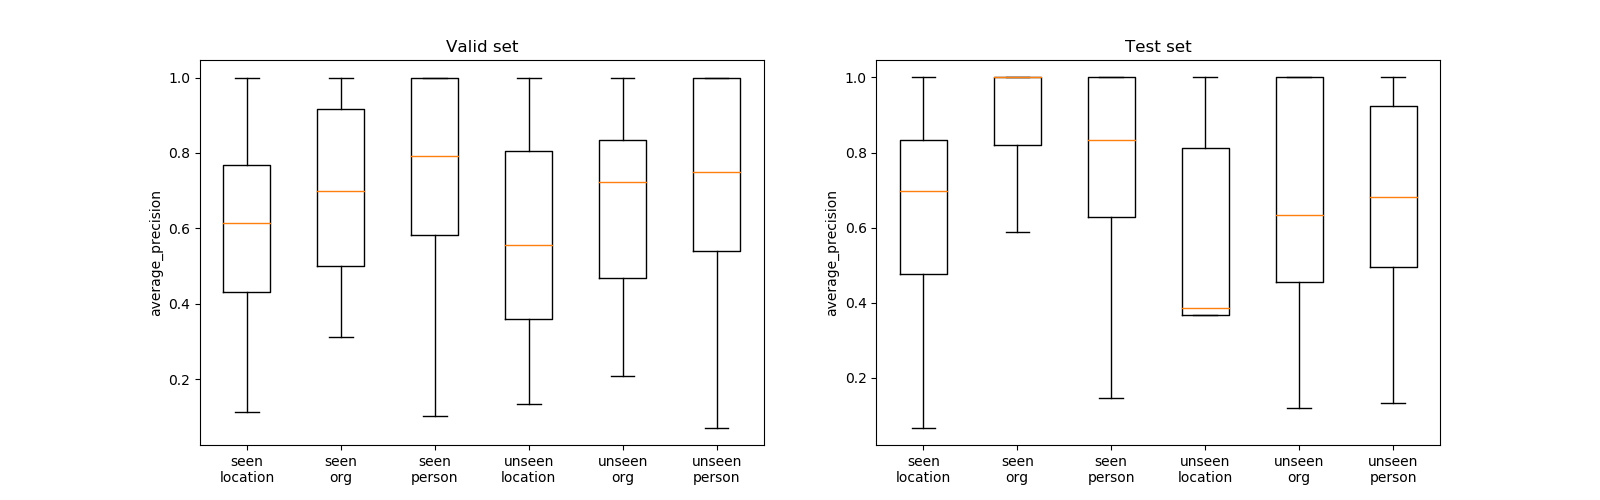

<IPython.core.display.Javascript object>


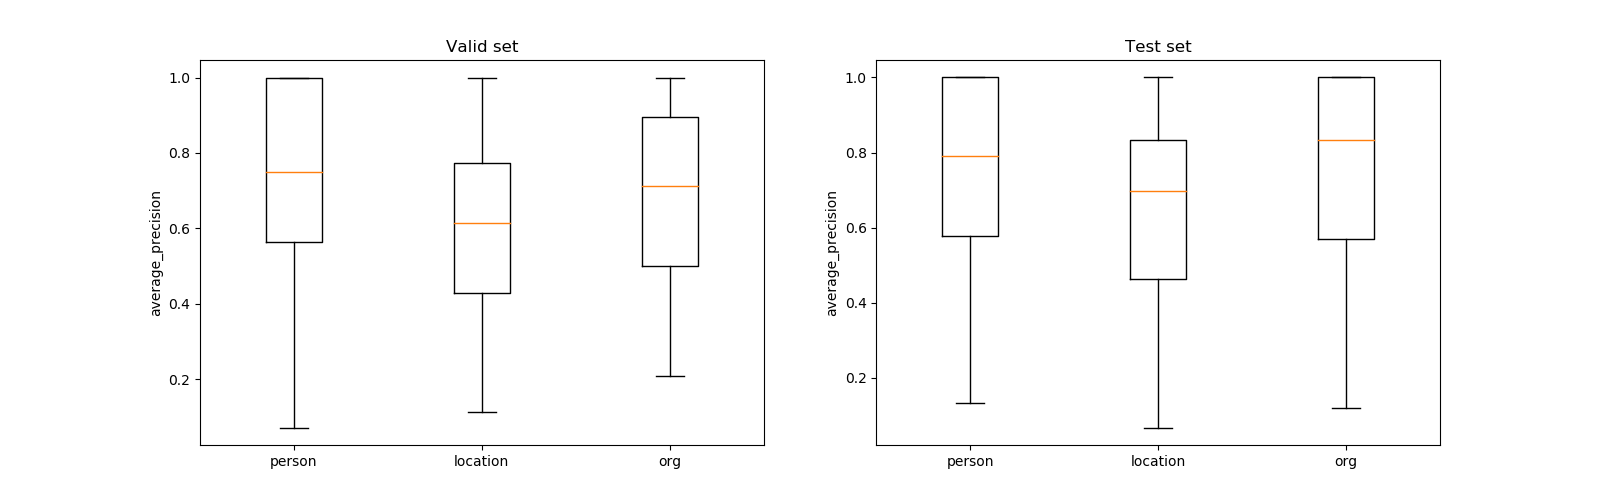

In [13]:
# Generative #
print("Generative")
key_score = "average_precision"
category_performance(dict_outputs_generative, key_score, seen_separation=True)
category_performance(dict_outputs_generative, key_score, seen_separation=False)

Discriminative


<IPython.core.display.Javascript object>


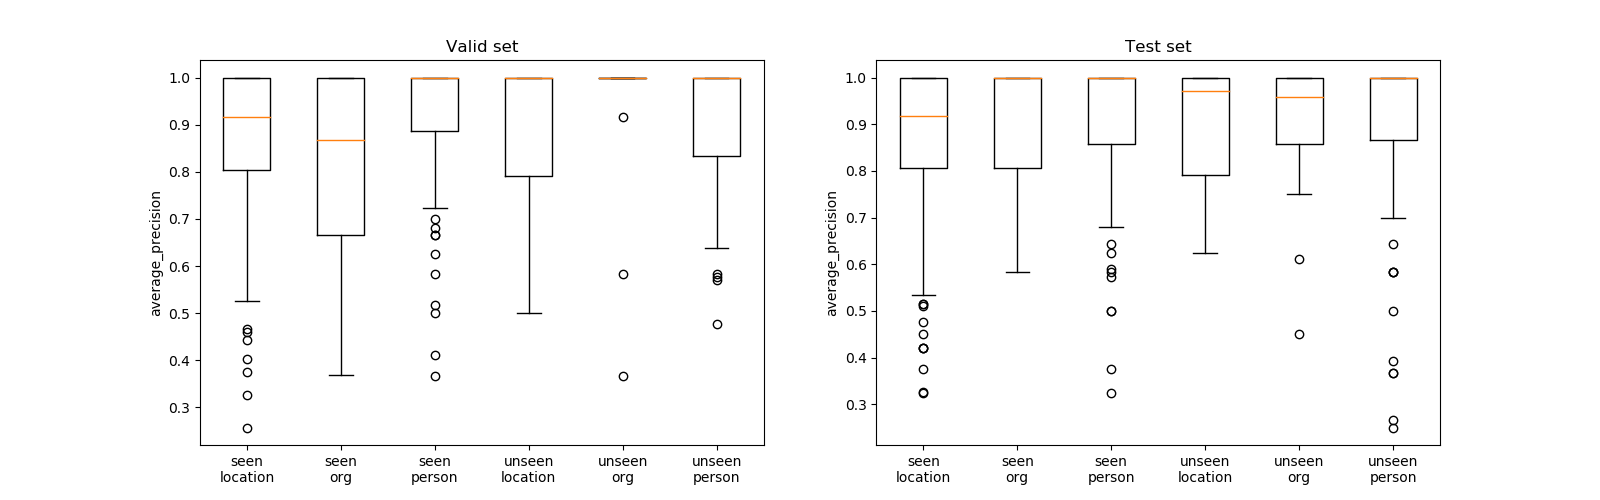

<IPython.core.display.Javascript object>


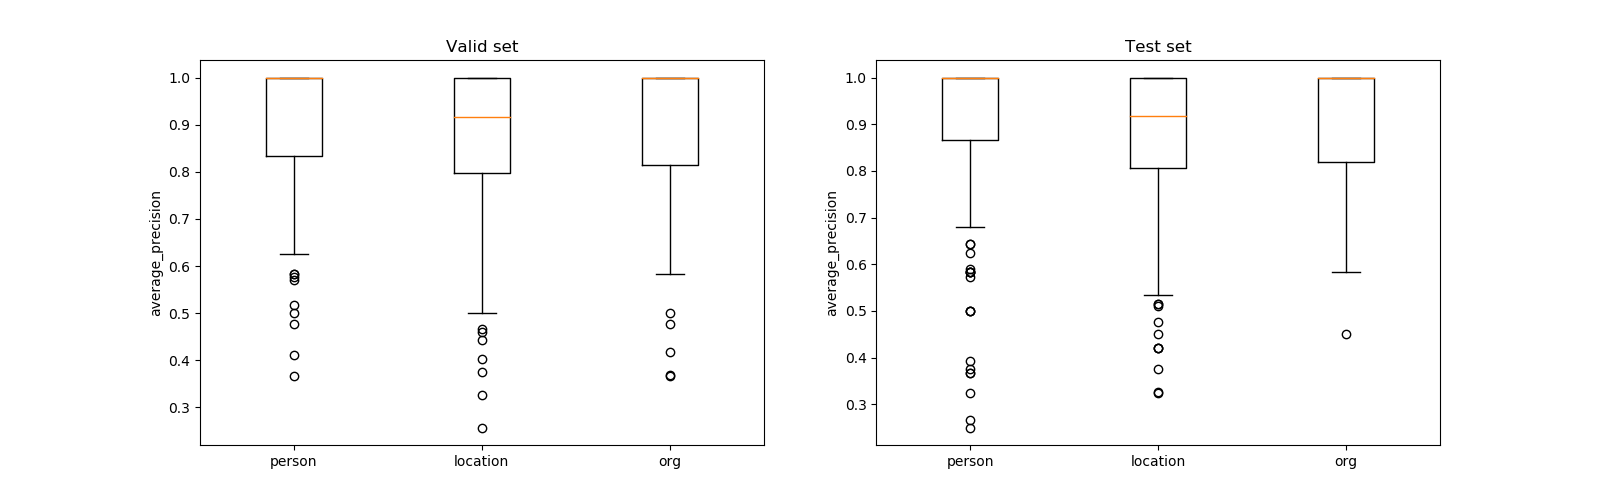

In [14]:
# Discriminative #
print("Discriminative")
key_score = "average_precision"
category_performance(dict_outputs_discriminative, key_score, seen_separation=True)
category_performance(dict_outputs_discriminative, key_score, seen_separation=False)

Discriminative


<IPython.core.display.Javascript object>


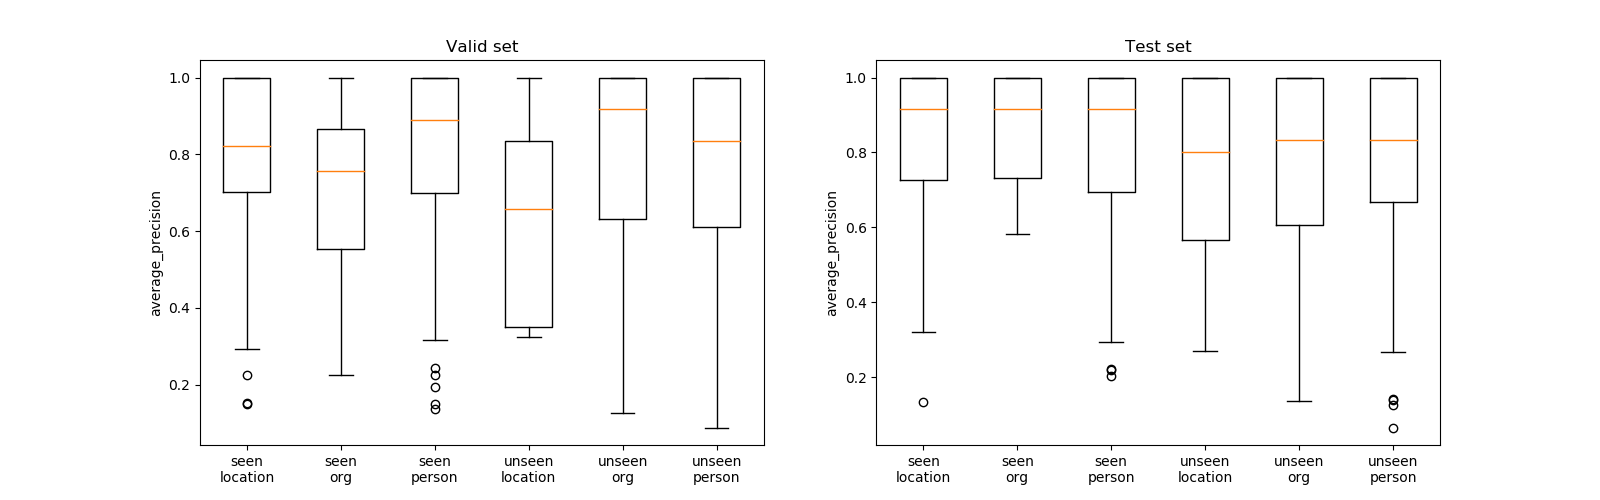

<IPython.core.display.Javascript object>


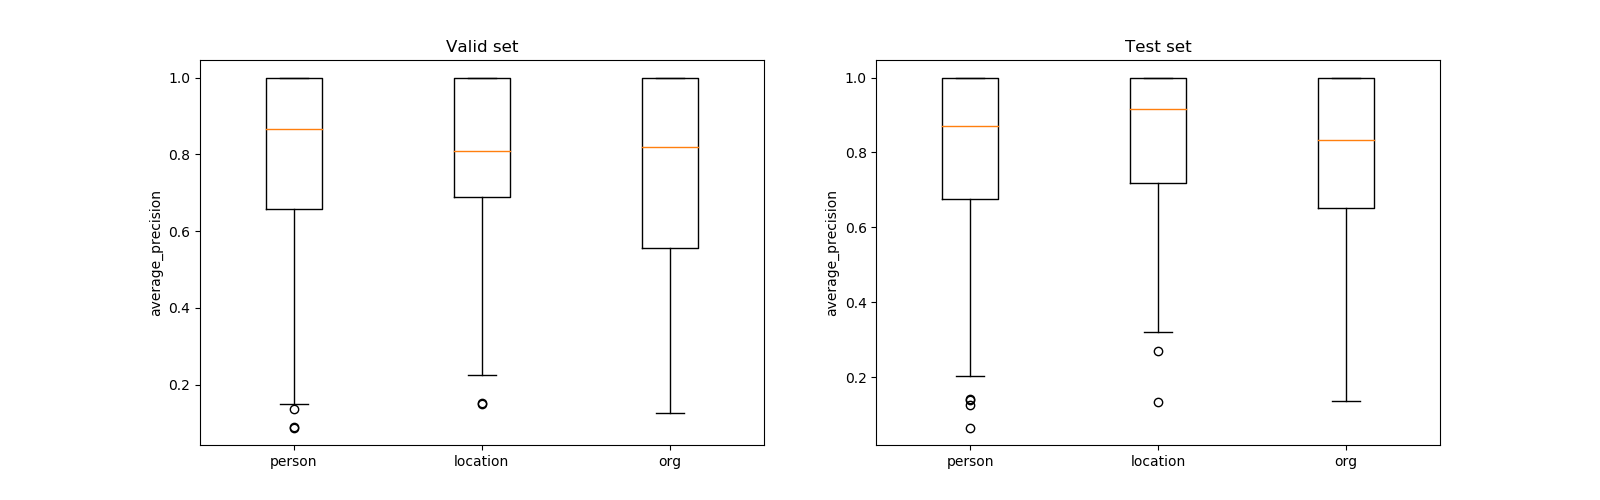

In [15]:
# Generative TFV2 #
print("Discriminative")
key_score = "average_precision"
category_performance(dict_outputs_generative_tfv2, key_score, seen_separation=True)
category_performance(dict_outputs_generative_tfv2, key_score, seen_separation=False)

#### Analyze performance in terms of number of entities

In [26]:
def number_entities_performance(dict_outputs, key_score):
    """
    Computes the average results, in terms of key_score, for the examples
    of (data_loader_key, seen_key, category_key) categorized by number of entities.
    """
    
    def performance_on_length(data_loader_key, axis):
        
        categories = list(dict_outputs[data_loader_key]["seen"].keys())
        lens = [[len(example["entities"])
                 for example in dict_outputs[data_loader_key][seen_key][category_key]] 
                for category_key, seen_key in itertools.product(categories,
                                                                ["seen", "unseen"])]
        
        lens = sorted(set(list(itertools.chain(*lens))))
        
        results_length = {category: {k:0 for k in lens} 
                                      for category in categories}
 
        normalize = {category: {k:0 for k in lens} 
                                 for category in categories}
        
        for category, seen_key in itertools.product(categories,
                                                    ["seen", "unseen"]):
            for example in dict_outputs[data_loader_key][seen_key][category]:
                bucket = len(example["entities"])
                score = example["scores"][key_score]
                results_length[category][bucket] += score
                normalize[category][bucket] += 1


        results_length = {category: {k: results_length[category][k] / normalize[category][k] 
                                     for k in lens if normalize[category][k] > 0} 
                          for category in categories}
        

        axis.set_title("%s set" % data_loader_key.capitalize())
        axis.set_xlim((lens[0], lens[-1]))
        axis.set_xticks(lens)
        axis.set_ylabel(key_score)
        axis.set_xlabel("Number of entities")
        for category in results_length:
            axis.plot(list(results_length[category].keys()),
                      list(results_length[category].values()),
                      'o-',
                      label=category,)
        
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    performance_on_length("valid", axs[0])
    performance_on_length("test", axs[1])
    

    axs[0].legend(bbox_to_anchor=(1.4, -0.1), ncol=3)
        
    plt.show()

Generative


<IPython.core.display.Javascript object>


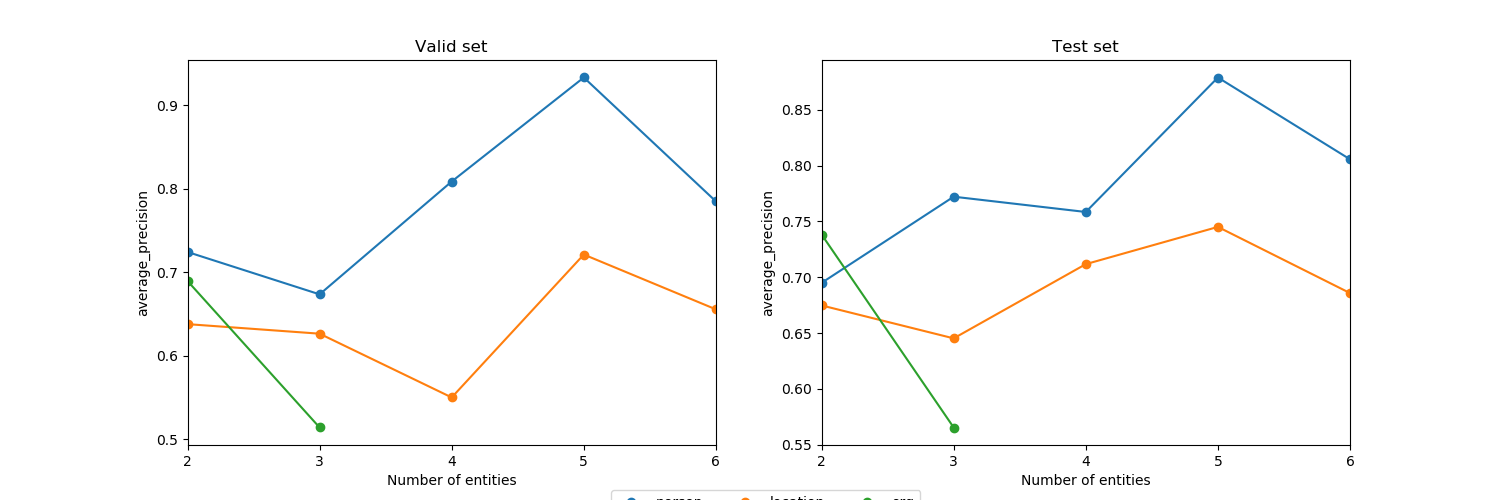

In [27]:
# Generative #
print("Generative")
key_score = "average_precision"
number_entities_performance(dict_outputs_generative, key_score)

Discriminative


<IPython.core.display.Javascript object>


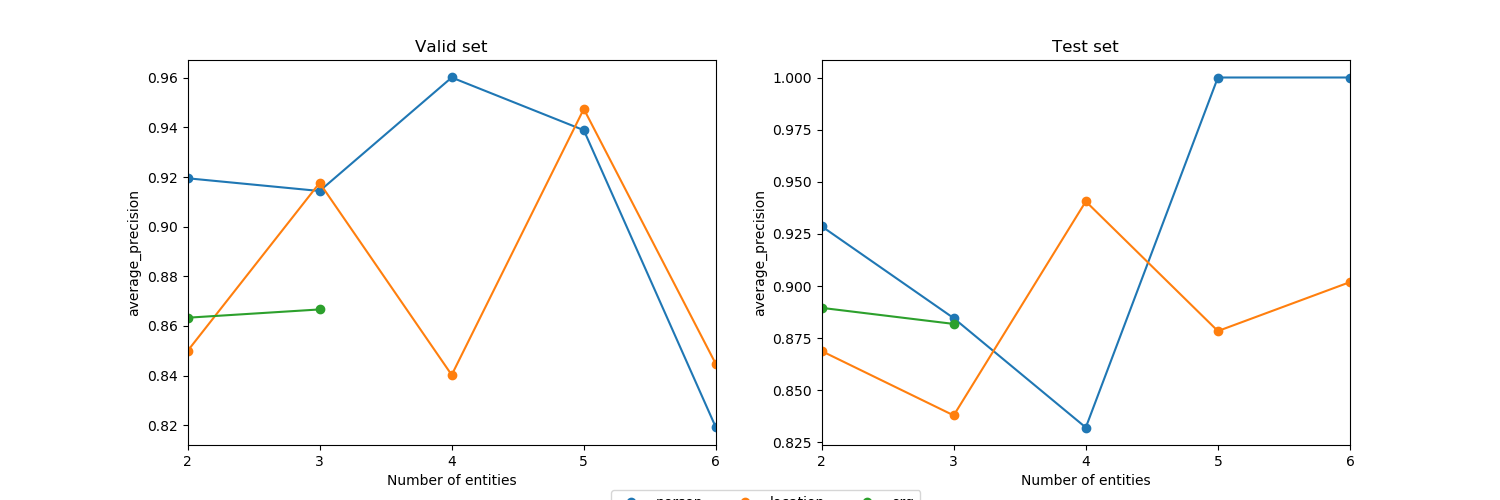

In [17]:
# Discriminative #
print("Discriminative")
key_score = "average_precision"
number_entities_performance(dict_outputs_discriminative, key_score)

#### Analyze the impact of non existing backgrounds

In [3]:
def background_performance(dict_outputs, key_score):
    """
    Diagrama de bigotes con los resultados de las instancias con con background completo 
    (todas las entidades tienen background) y las instancias con background faltantes.
    """
    
    def performance_on_set(data_loader_key, axis):
        categories = list(dict_outputs[data_loader_key]["seen"])
        full_back_performances = [] 
        part_back_performances = []

        for seen_key, category_key in itertools.product(["seen", "unseen"], categories):
            for example in dict_outputs[data_loader_key][seen_key][category_key]:
                if all(example["background"]):
                    full_back_performances.append(example["scores"][key_score])
                else:
                    part_back_performances.append(example["scores"][key_score])
                    

        axis.set_title("%s set" % data_loader_key.capitalize())
        axis.set_ylabel(key_score)
        print(sum(full_back_performances) / len(full_back_performances))
        print(sum(part_back_performances) / len(part_back_performances))
        axis.boxplot([full_back_performances, part_back_performances],
                    labels=["Full\nBackground", "Partial\nBackground"])
    
 
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    performance_on_set("valid", axs[0])
    performance_on_set("test", axs[1])
    plt.show()

Generative


<IPython.core.display.Javascript object>


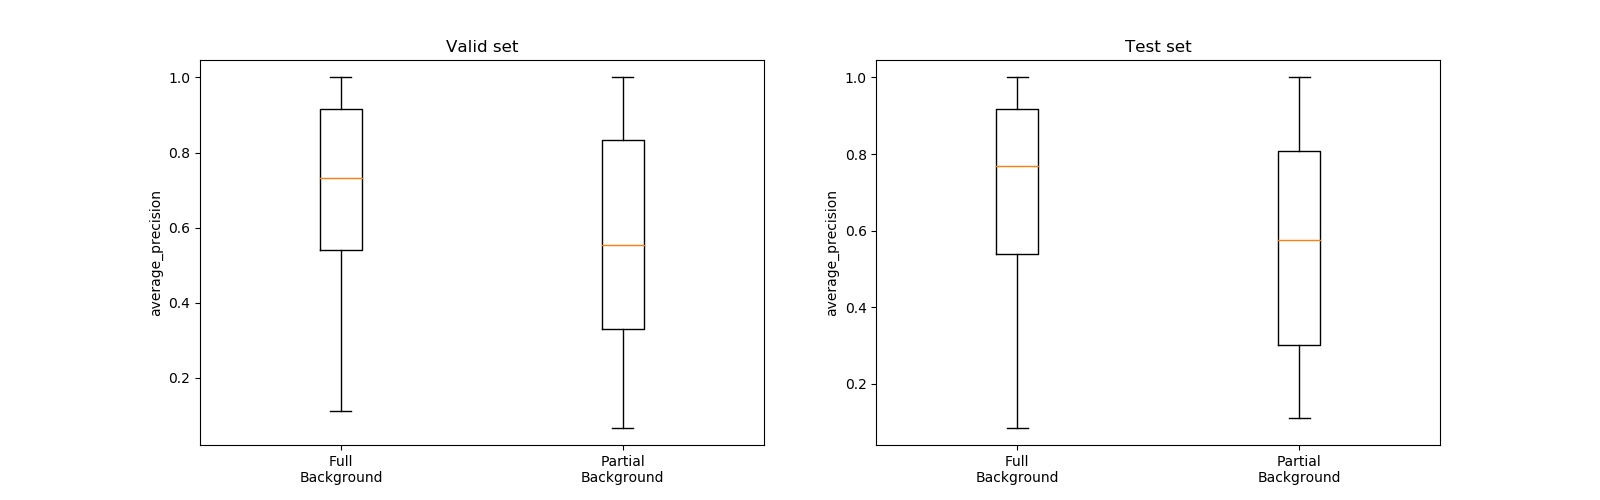

0.706093207836314
0.5639136084355414
0.7234899876484884
0.5822884058031965


In [6]:
print("Generative")
key_score = "average_precision"
background_performance(dict_outputs_generative, key_score)

Discriminative


<IPython.core.display.Javascript object>


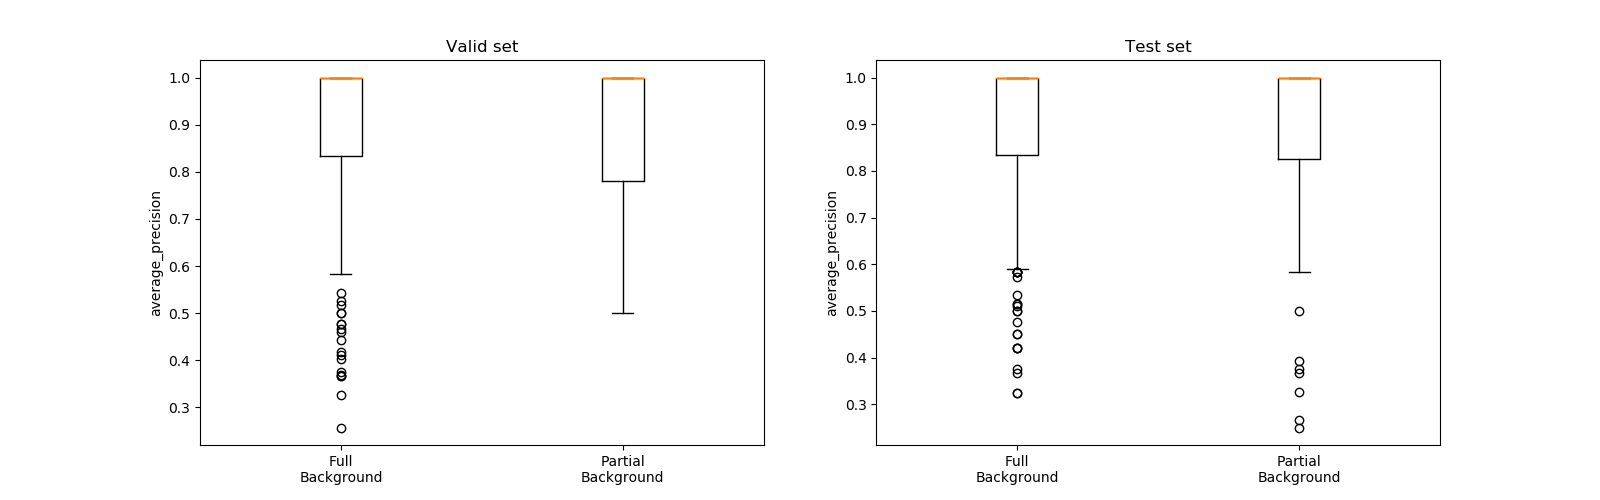

0.8949634723487447
0.8832067362964153
0.903556164127687
0.8683893115204924


In [5]:
print("Discriminative")
key_score = "average_precision"
background_performance(dict_outputs_discriminative, key_score)

#### Ranking confusion matrix

In [19]:
def compute_confusion_dict(dict_outputs, data_loader, category):
    """
    Each key of the dictionary is an aggregation that appeared as gold standard in some ranking.
    Each value is a list of distractors that appeared before in the ranking than the key.
    """
    confusion_dict = {}
    rankings = (dict_outputs[data_loader]["seen"][category] + 
                dict_outputs[data_loader]["unseen"][category])
    
    for ranking in rankings:
        targets = np.array(ranking["targets"])
        ranks = np.array(ranking["ranks"])
        choices = np.array(ranking["choices"])
        
        gold_standards = choices[targets==1]
        distractors = choices[targets==0]
        
        gold_standard_ranks = ranks[targets==1]
        distractor_ranks = ranks[targets==0]
        
        for gold_idx, gold_standard_rank in enumerate(gold_standard_ranks):
            gold_standard = gold_standards[gold_idx]
            
            if gold_standard not in confusion_dict:
                confusion_dict[gold_standard] = [1, []]
            else:
                confusion_dict[gold_standard][0] += 1
                
            for dist_idx, distractor_rank in enumerate(distractor_ranks):
                distractor = distractors[dist_idx]
                
                if distractor_rank < gold_standard_rank:
                    
                    confusion_dict[gold_standard][1].append(distractor)

    return confusion_dict

In [20]:
def analyze_confusion_dict(confusion_dict, topk):
    print("Total number of confusions: %d (%d confused aggregations)" 
          % (sum([len(v) for _, [_, v] in confusion_dict.items()]), len(confusion_dict)))
    
    # Show choices 
    print("\nChoices sorted by number of confusions:\n")
    most_confused = sorted(confusion_dict.items(), 
                           key=lambda item: len(item[1][1]), 
                           reverse=True)
    for choice, (occurences, confusions) in most_confused:
        print("*) \"%s\" confused by other %i choices (appears in %i rankings)" % 
              (choice, len(confusions), occurences))
    
    print("\n\n" + "-"*50 + "\n\n")
    
    # Show most confused pairs
    pairs_confused = []
    for choice, (occurences, confusions) in confusion_dict.items():
        counter = Counter(confusions)
        for distractor in counter:
            pairs_confused.append((choice, distractor, counter[distractor]))

    pairs_confused = sorted(pairs_confused, key=lambda x: x[2], reverse=True)
    print("\nTop %d most confused pairs\n" % topk)
    for i in range(topk):
        gold = pairs_confused[i][0]
        distractor = pairs_confused[i][1]
        n_confusions = pairs_confused[i][2]
        print("*) \"%s\" - \"%s\" (%d times)" % (gold, distractor, n_confusions))

In [70]:
def get_topk_confusions(confusion_dict, topk):
    most_confused = sorted(confusion_dict.items(), 
                           key=lambda item: len(item[1][1]), 
                           reverse=False)
    return [(k, v[0], len(v[1])) for k, v in most_confused[:topk]]

In [71]:
def compare_confusions(confusion_dict_generative, confusion_dict_discriminative):
    assert len(confusion_dict_generative) == len(confusion_dict_discriminative)
    more_confused = []
    
    for key in confusion_dict_generative:
        if len(confusion_dict_discriminative[key][1]) < len(confusion_dict_generative[key][1]):
            more_confused.append((key, 
                                  len(confusion_dict_generative[key][1]),
                                  len(confusion_dict_discriminative[key][1]),
                                  confusion_dict_discriminative[key][0]
                                 ))
    
    more_confused = sorted(more_confused, key=lambda x: x[1] - x[2], reverse=True)
    print("{: >20} {: >20} {: >20} {: >20}".format("Agg", "Gen", "Disc", "NRanks"))
    for key, confused_generative, confused_discriminative, nranks in more_confused:
        print("{: >20} {: >20} {: >20} {: >20}".format(key, confused_generative, 
                                                       confused_discriminative, nranks))

In [73]:
get_topk_confusions(confusion_dict_generative_tfv2, 200)

[('western asian countries', 17, 0),
 ('asian countries', 20, 0),
 ('middle eastern countries', 21, 0),
 ('us states', 3, 0),
 ('states', 7, 0),
 ('american states', 7, 0),
 ('southern states', 1, 0),
 ('regional powers', 1, 0),
 ('cities', 3, 0),
 ('american cities', 3, 0),
 ('western asian regions', 1, 0),
 ('eastern european countries', 1, 0),
 ('iraqi regions', 1, 0),
 ('allies', 1, 0),
 ('african nations', 2, 0),
 ('united states cities', 1, 0),
 ('south asian countries', 2, 0),
 ('southern asian countries', 1, 0),
 ('american destinations', 1, 0),
 ('palestinian areas', 1, 0),
 ('regions', 5, 0),
 ('new york region', 1, 0),
 ('southeast asian countries', 1, 0),
 ('chinese areas', 1, 0),
 ('east asian countries', 3, 0),
 ('african regions', 1, 0),
 ('middle eastern nations', 3, 0),
 ('middle eastern areas', 1, 0),
 ('european nations', 1, 0),
 ('political rivals', 1, 0),
 ('western asia cities', 1, 0),
 ('eastern countries', 1, 0),
 ('somalian areas', 2, 0),
 ('african areas', 1, 

In [67]:
data_loader = "test"
category = "location"
confusion_dict_generative = compute_confusion_dict(dict_outputs_generative, data_loader, category)
confusion_dict_discriminative = compute_confusion_dict(dict_outputs_discriminative, data_loader, category)
confusion_dict_generative_tfv2 = compute_confusion_dict(dict_outputs_generative_tfv2, data_loader, category)

In [24]:
compare_confusions(confusion_dict_generative, confusion_dict_discriminative)#confusion_dict_generative_tfv2)

                 Agg                  Gen                 Disc               NRanks
                 men                  109                    1                   13
             writers                   70                    2                   12
             authors                   40                    1                    5
             leaders                   37                    0                    3
      family members                   24                    2                    4
 media personalities                   25                    5                    5
           americans                   25                    6                   23
                ceos                   20                    1                    2
    football workers                   20                    1                    4
        boardmembers                   19                    0                    1
              german                   20                    1              

In [41]:
print("Generative")
topk = 30
analyze_confusion_dict(confusion_dict_generative, topk)

Generative
Total number of confusions: 1146 (175 rankings)

Choices sorted by number of confusions:

*) "countries" confused by other 118 choices (appears in 44 rankings)
*) "nations" confused by other 111 choices (appears in 40 rankings)
*) "states" confused by other 60 choices (appears in 7 rankings)
*) "world powers" confused by other 39 choices (appears in 11 rankings)
*) "political powers" confused by other 39 choices (appears in 41 rankings)
*) "regions" confused by other 34 choices (appears in 5 rankings)
*) "world locations" confused by other 23 choices (appears in 2 rankings)
*) "oil recipients" confused by other 21 choices (appears in 1 rankings)
*) "governmental regions" confused by other 21 choices (appears in 1 rankings)
*) "global powers" confused by other 19 choices (appears in 2 rankings)
*) "oil bound areas" confused by other 19 choices (appears in 1 rankings)
*) "very different regions" confused by other 18 choices (appears in 1 rankings)
*) "important countries" conf

In [42]:
print("Discriminative")
topk = 30
analyze_confusion_dict(confusion_dict_discriminative, topk)

Discriminative
Total number of confusions: 348 (175 rankings)

Choices sorted by number of confusions:

*) "asian places" confused by other 19 choices (appears in 1 rankings)
*) "european locations" confused by other 17 choices (appears in 1 rankings)
*) "european places" confused by other 16 choices (appears in 1 rankings)
*) "areas involved in the dispute" confused by other 14 choices (appears in 1 rankings)
*) "governmental regions" confused by other 11 choices (appears in 1 rankings)
*) "geographic locales" confused by other 10 choices (appears in 2 rankings)
*) "eastern countries" confused by other 10 choices (appears in 1 rankings)
*) "world powers" confused by other 9 choices (appears in 11 rankings)
*) "acrimonious countries" confused by other 9 choices (appears in 1 rankings)
*) "eastern hemisphere geographic regions" confused by other 8 choices (appears in 1 rankings)
*) "islamic powers" confused by other 8 choices (appears in 1 rankings)
*) "regional powers" confused by othe

In [44]:
print("Generative TF V2")
topk = 30
analyze_confusion_dict(confusion_dict_generative_tfv2, topk)

Generative TF V2
Total number of confusions: 662 (175 rankings)

Choices sorted by number of confusions:

*) "geographic locales" confused by other 24 choices (appears in 2 rankings)
*) "israeli territories" confused by other 21 choices (appears in 1 rankings)
*) "very different regions" confused by other 19 choices (appears in 1 rankings)
*) "heavily populated areas" confused by other 18 choices (appears in 1 rankings)
*) "oil recipients" confused by other 17 choices (appears in 1 rankings)
*) "portugal properties" confused by other 17 choices (appears in 1 rankings)
*) "acrimonious countries" confused by other 16 choices (appears in 1 rankings)
*) "islamic powers" confused by other 16 choices (appears in 1 rankings)
*) "places near the pacific ocean" confused by other 15 choices (appears in 1 rankings)
*) "opposing political regions" confused by other 15 choices (appears in 1 rankings)
*) "sunny locations" confused by other 14 choices (appears in 1 rankings)
*) "middle east hot spots

#### why men, countries and nations? analysis

In [29]:
def why_choice(dict_outputs, data_loader, category, choice):
    rankings = [ranking for ranking in dict_outputs[data_loader]["seen"][category] + \
                                       dict_outputs[data_loader]["unseen"][category] 
                if choice in ranking["choices"] and ranking["targets"][ranking["choices"].index(choice)]]
    
    rankings = sorted(rankings, key=lambda x: x["scores"]["average_precision"])
    pretty_print(rankings, "./aaa")

In [30]:
why_choice(dict_outputs_generative, "test", "person", "men")

Example 1/13: 

Entities (person): Richard Trank, Simon Wiesenthal

Context:
Simon Wiesenthal was a Jewish Austrian Holocaust survivor, Nazi hunter, and writer. He studied architecture and was living in Lwów at the outbreak of World War II. He survived the Janowska concentration camp , the Kraków-Płaszów concentration camp , the Gross-Rosen concentration camp, a death march to Chemnitz, Buchenwald, and the Mauthausen-Gusen concentration camp . I Have Never Forgotten You: Directed by Richard Trank Not rated; 105 minutes The legacy of the concentration camp survivor and Nazi hunter Simon Wiesenthal is one of unimpeachable bravery, but'' I Have Never Forgotten You,'' a new documentary, is a suspect monument to his courage. Directed by Richard Trank , also its co-author , the film effectively sketches Mr. Wiesenthal 's life, from his tenacity in surviving the genocide that claimed much of his family, to his determination to identify, find and punish ex-Nazis after World War II, at a time w

In [31]:
why_choice(dict_outputs_generative, "test", "location", "countries")

Example 1/44: 

Entities (location): Iran, Syria

Context:
Iran, also called Persia, and officially the Islamic Republic of Iran, is a country in Western Asia. With 82 million inhabitants, Iran is the world's 18th most populous country. Its territory spans 1,648,195 km2 , making it the second largest country in the Middle East and the 17th largest in the world. Iran is bordered to the northwest by Armenia and the Republic of Azerbaijan, to the north by the Caspian Sea, to the northeast by Turkmenistan, to the east by Afghanistan and Pakistan, to the south by the Persian Gulf and the Gulf of Oman, and to the west by Turkey and Iraq. Syria , officially the Syrian Arab Republic , is a country in Western Asia, bordering Lebanon to the southwest, the Mediterranean Sea to the west, Turkey to the north, Iraq to the east, Jordan to the south, and Israel to the southwest. A country of fertile plains, high mountains, and deserts, Syria is home to diverse ethnic and religious groups, including Sy

#### Hierarchy

In [32]:
entities = [ranking["choices"] for ranking in dict_outputs_generative["test"]["seen"]["person"]] + \
           [ranking["choices"] for ranking in dict_outputs_generative["test"]["unseen"]["person"]]
entities = list(set(itertools.chain(*entities)))

In [33]:
sorted(entities, key=lambda x: len(x.split()))

['renovators',
 'designers',
 'investigators',
 'criminals',
 'speakers',
 'executives',
 'adults',
 'ex-presidents',
 'german',
 'staffers',
 'businessman',
 'geniuses',
 'policemen',
 'therapists',
 'journalists',
 'olympians',
 'austrians',
 'entrepreneurs',
 'boardmembers',
 'enemies',
 'aleksandrs',
 'scribes',
 'scientists',
 'ceylans',
 'commentators',
 'aquaintences',
 'celebrities',
 'ukrainians',
 'audiophiles',
 'opponents',
 'players',
 'mafiosos',
 'homeowners',
 'cooks',
 'acquaintances',
 'catholics',
 'parents',
 'grandmasters',
 'women',
 'environmentalists',
 'funnymen',
 'associates',
 'democats',
 'lawyers',
 'moguls',
 'businesspeople',
 'musician',
 'hispanics',
 'politician',
 'contemporaries',
 'statesmen',
 'advisers',
 'creatives',
 'filmmakers',
 'defendants',
 'athletes',
 'dead',
 'victims',
 'contractors',
 'entertainers',
 'american',
 'officers',
 'fishermen',
 'businessmen',
 'israelis',
 'boxers',
 'politicicans',
 'socialites',
 'assailants',
 'chance

DBPedia classes:
http://mappings.dbpedia.org/server/ontology/classes/
I think it is quite "flattened" person -> politician (leaf)
                                place -> settlement -> city (leaf)
                                organization -> company (leaf)
                           
                                
Wordnet *:
hypernyms and hyponyms, I think it's quite suitable for the task (visual inspection). Some specializations
are not synsets, but it is quite lexical -> american politicians, renowned artists, convicted criminals, ... (Qualifier+Noun) (convicted criminals <- criminals <- person) and the noun are synsets.
https://www.cs.princeton.edu/courses/archive/spring07/cos226/assignments/wordnet.html


Wikipedia:

Api: https://en.wikipedia.org/w/api.php?action=query&list=categorymembers&cmnamespace=14&cmlimit=max&cmtitle=Category:main%20topic%20classifications

It will require a lot of preprocessing (members, list, .. by location, .. by location and occupation, ...
I'm preparing the data for generate the graph from wikipedia dumps and reading about it.
https://www.mediawiki.org/wiki/Manual:Categorylinks_table